In [12]:
import numpy as np
import pandas as pd

In [59]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = 9, 6

In [60]:
def load_titanic():
    """
    Загружает данные Титаника и возвращает с виде одного датасета 
    с признаком is_test и данные выживания для тестовой выборки
    """
    X_train = pd.read_csv('titanic/train.csv')
    X_test = pd.read_csv('titanic/test.csv')
    X_train['is_test'] = 0
    X_test['is_test'] = 1    
    y_train = X_train.Survived
    X_train.drop('Survived', axis=1, inplace=True)
    return pd.concat([X_train, X_test]), y_train

In [61]:
Titles_map = {
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",   
    "Lady" :       "Royalty"    
    "Dona":        "Royalty",    
    "the Countess":"Royalty",
    
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",    
    "Dr":         "Officer",
    "Rev":        "Officer",

    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
}


def clean_data(X):
    """Очищает исхожные данные и кодирует нечисловые значения"""
    # Сохраняем ID пассажира для создания файла с ответами для постинга на Kaggle
    # и is_test для последующего разделения датасета на тестовый и тренировочный
    # в отдельных pd.Series и удаляем эти колонки из датасета
    PassengerId = X[X.is_test == 1].PassengerId
    is_test = X.is_test
    X = X.drop(['is_test', 'PassengerId'], axis=1)
    
    # Пол
    print('\n------Sex')
    print(X.Sex.value_counts())    
    X.Sex = X.Sex.map({"male": 1, "female":0})
    
    # Обращение
    X['Title'] = X.Name.map(lambda name: name.split(',')[1].split('.')[0].strip())
    X['Title'] = X.Title.map(Titles_map)
    print('\n------Titles')
    print(X.Title.value_counts())
    X = pd.get_dummies(X, columns=['Title'])
    
    # Возраст (для отсутствующих значений берём медиану)
    X.Age = X.Age.fillna(X.Age.median())
    rcParams['figure.figsize'] = 12, 6
    fig, axes = plt.subplots(nrows=1, ncols=2)
    X.Age.hist(ax=axes[0])
    axes[0].set_title('Возраст')
    
    # Стоимость (для отсутствующих значений берём медиану)
    X.Fare = X.Fare.fillna(X.Fare.median())
    X.Fare.hist(ax=axes[1])
    axes[1].set_title('Стоимость')
    
    # Размер семьи
    print('\n------FamilySize')
    X['FamilySize'] = X.SibSp + X.Parch + 1
    print(X.FamilySize.value_counts())   
    
    # Класс пассажира
    print('\n------Pclass')
    print(X.Pclass.value_counts())     
    
    # Порт посадки
    print('\n------Embarked')
    print(X.Embarked.value_counts()) 
    X.Embarked = X.Embarked.fillna('S')
    X = pd.get_dummies(X, columns=['Embarked'])
    
    # Удаляем номер билета, каюты и имя пассажира
    X = X.drop(['Cabin', "Ticket", "Name"], axis=1)
    
    return X, is_test, PassengerId

In [62]:
from sklearn.preprocessing import StandardScaler

def normalize_data(X):
    """Возвращает нормализованные значения"""
    columns = X.columns
    index = X.index
    X = pd.DataFrame(StandardScaler().fit_transform(X), columns=columns)
    X.index = index
    return X

In [63]:
def split_data(X, is_test):
    """Разделяет данные на тренировочную и тестовую выбрки по сохранённому флагу is_test"""
    X_train = X[is_test == 0]
    X_test = X[is_test == 1]
    return X_train, X_test

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def tune_model(X, y):
    """Тюнит дерево решений и возвращает топ-5 лучших результатов"""    
    cv = StratifiedKFold(y_train, n_folds=3, shuffle=True, random_state=1)
    grid = GridSearchCV(DecisionTreeClassifier(), {
        'max_depth': range(2, 10),  
        "min_samples_split": [2, 3, 4, 5, 6, 8, 10],
        "min_samples_leaf": [1, 2, 4]        
    }, cv=cv, scoring='accuracy', refit=True, n_jobs=-1)
    grid.fit(X, y)    
    return sorted(grid.grid_scores_, key = lambda x: -x.mean_validation_score)[:5]

In [65]:
from sklearn.model_selection import cross_val_score

def get_prediction(X, y, X_test,**classifier_kwargs):
    """Тренирует модель и возвращает предсказания"""
    clf = DecisionTreeClassifier(**classifier_kwargs)
    clf.fit(X, y)
    score = cross_val_score(clf, X, y, cv=60, scoring='accuracy').mean()
    predict = clf.predict(X_test)
    predict_proba = clf.predict_proba(X_test)
    print("cross_val accuracy score: {}".format(score))
    return predict, predict_proba, clf

In [66]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

def plot_roc_curve(y, y_predict_proba):
    """Рисует кривую ROC"""
    fpr, tpr, thres = roc_curve(y, y_predict_proba[:, 1])
    plt.plot(fpr, tpr);
    plt.title('ROC: {:.3f}'.format(roc_auc_score(y, y_predict_proba[:, 1])))

In [67]:
def save_submission(file_name, PassengerId, predict):
    """Сохраняет результат в файл"""
    submussion = 'PassengerId,Survived\n'
    submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(PassengerId, predict)])
    
    with open(file_name, 'w') as file:
        file.write(submussion)    

In [68]:
from sklearn.tree import export_graphviz

def get_tree_dot_view(clf, feature_names=None, class_names=None):
    """Возвращает граф дерева для graphviz"""
    return export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names)

## Получаем данные и тюним модель


------Sex
male      843
female    466
Name: Sex, dtype: int64

------Titles
Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

------FamilySize
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: FamilySize, dtype: int64

------Pclass
3    709
1    323
2    277
Name: Pclass, dtype: int64

------Embarked
S    914
C    270
Q    123
Name: Embarked, dtype: int64


/Users/ur001/.pyenv/versions/anaconda3-5.0.0/envs/netology1/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.81594, std: 0.01299, params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2},
 mean: 0.81594, std: 0.01299, params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3},
 mean: 0.81594, std: 0.01299, params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 4},
 mean: 0.81594, std: 0.01299, params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5},
 mean: 0.81594, std: 0.01299, params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 6}]

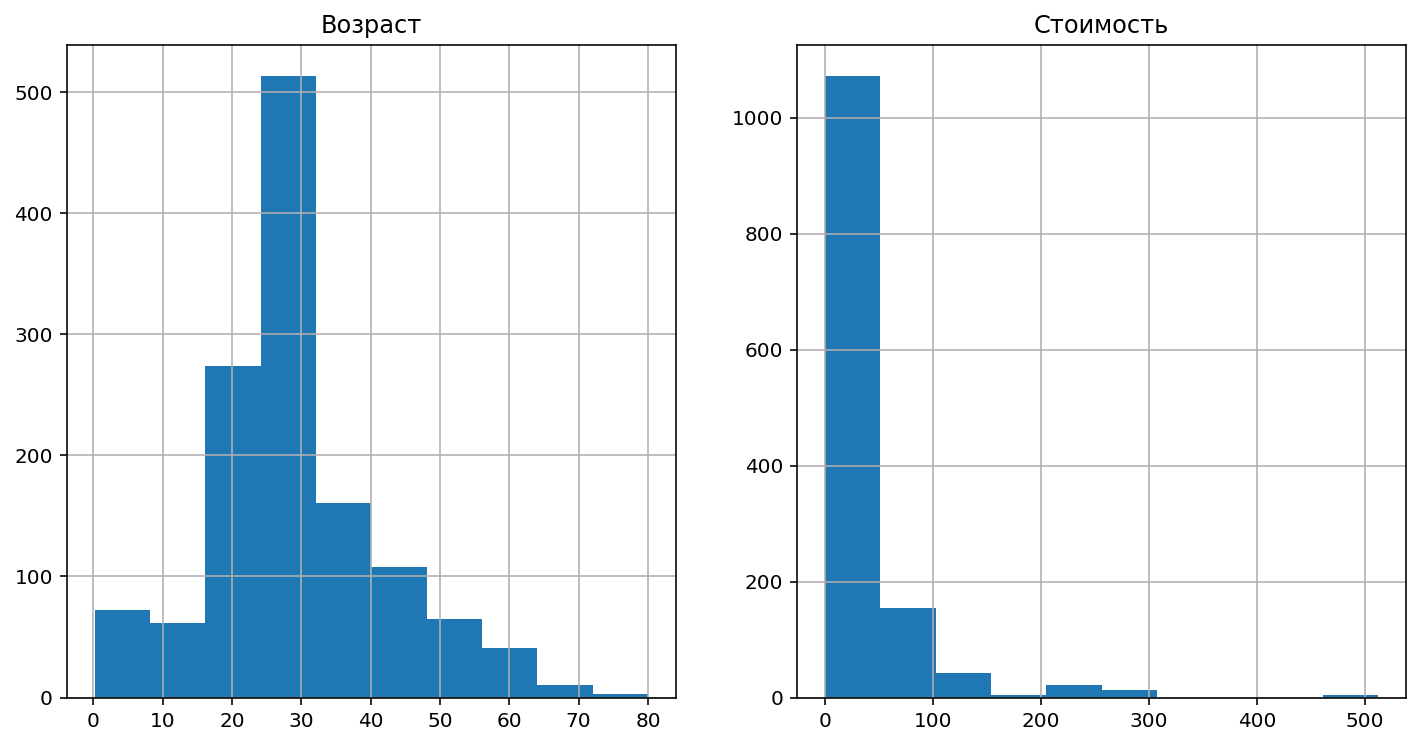

In [69]:
X, y_train = load_titanic()
X, is_test, PassengerId = clean_data(X)
X = normalize_data(X)
X_train, X_test = split_data(X, is_test)
tune_model(X_train, y_train)

## Тренировка на тестовых данных

cross_val accuracy score: 0.7974747474747476
test prediction accuracy:  0.854748603352


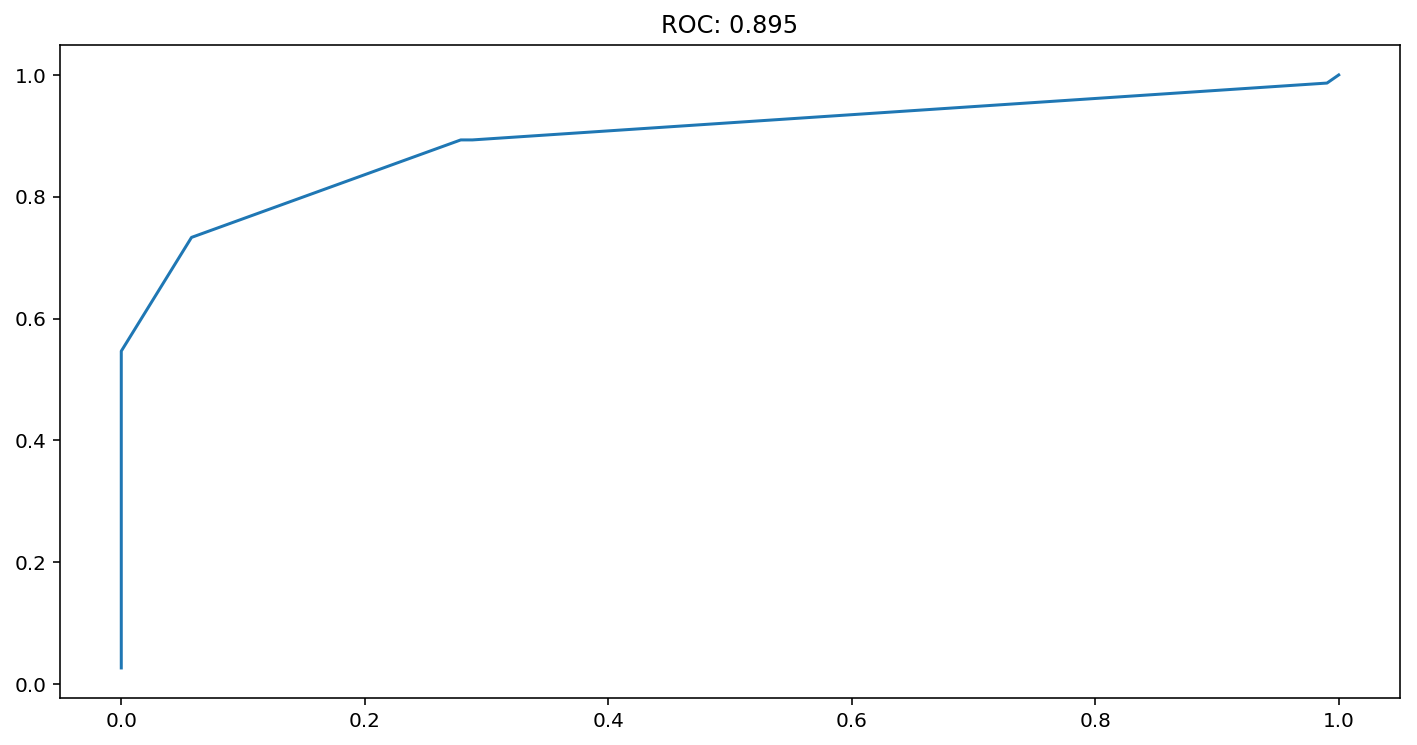

In [70]:
from sklearn.model_selection import train_test_split
classifier_kwargs = dict(max_depth=3, min_samples_leaf=1, min_samples_split=2)

# Делим тренировочные данные на тестовые и проверочные
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.2)

# Делаем предсказания для проверочных данных
y_train_test_predict, y_train_test_predict_proba, model = get_prediction(
    X_train_train, y_train_train, X_train_test, **classifier_kwargs
)

# Рисуем ROC-кривую и выводим accuracy score
plot_roc_curve(y_train_test, y_train_test_predict_proba)
print("test prediction accuracy: ", accuracy_score(y_train_test, y_train_test_predict))

### Финальное предсказание

In [71]:
y_test_predict, y_test_predict_proba, model = get_prediction(X_train, y_train, X_test, **classifier_kwargs)    

cross_val accuracy score: 0.8286210317460315


In [72]:
save_submission('submission.txt', PassengerId, y_test_predict)

## Дерево решений

In [73]:
print(get_tree_dot_view(model, list(X.columns), ['no', 'yes']))

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Title_Mr <= -0.159\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = no", fillcolor="#e5813960"] ;
1 [label="FamilySize <= 1.653\ngini = 0.422\nsamples = 374\nvalue = [113, 261]\nclass = yes", fillcolor="#399de591"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Fare <= -0.288\ngini = 0.346\nsamples = 323\nvalue = [72, 251]\nclass = yes", fillcolor="#399de5b6"] ;
1 -> 2 ;
3 [label="gini = 0.461\nsamples = 150\nvalue = [54, 96]\nclass = yes", fillcolor="#399de570"] ;
2 -> 3 ;
4 [label="gini = 0.186\nsamples = 173\nvalue = [18, 155]\nclass = yes", fillcolor="#399de5e1"] ;
2 -> 4 ;
5 [label="Pclass <= 0.245\ngini = 0.315\nsamples = 51\nvalue = [41, 10]\nclass = no", fillcolor="#e58139c1"] ;
1 -> 5 ;
6 [label="gini = 0.0\nsamples = 6\nvalue = [0, 6]\nclass = yes", fillcolor="#399de5ff"] ;
5 -> 6 ;
7 [label="gini = 0.162\nsamples = 45\nvalue = [41, 4]\nclass = no", fillcolor="#e5813

## Вариант на RandomForestClassifier

In [79]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(y_train, n_folds=3, shuffle=True)
model = RandomForestClassifier(random_state=1)
params = [{
    "n_estimators": [350, 400, 450],
    "min_samples_split": [6, 8, 10],
    "min_samples_leaf": [1, 2, 4]
}]
grid = GridSearchCV(model, params, cv=cv, refit=True, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   10.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)


In [80]:
model = RandomForestClassifier(n_estimators=400, min_samples_split=6, min_samples_leaf=4)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)

In [81]:
score

0.8350168350168351

In [82]:
save_submission('submission2.txt', PassengerId, y_test_predict)

## Kaggle Score: 0.7799...